<a href="https://colab.research.google.com/github/jagtapuday/Facial-Emotion-Recognition/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [ ]:
sns.set_style("whitegrid")

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 52% 10.0M/19.3M [00:00<00:00, 27.3MB/s]
100% 19.3M/19.3M [00:00<00:00, 48.9MB/s]
 71% 65.0M/92.0M [00:02<00:01, 17.2MB/s]
100% 92.0M/92.0M [00:02<00:00, 45.5MB/s]
 93% 90.0M/96.6M [00:01<00:00, 62.5MB/s]
100% 96.6M/96.6M [00:01<00:00, 90.7MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 6.36MB/s]
 84% 65.0M/77.3M [00:00<00:00, 31.2MB/s]
100% 77.3M/77.3M [00:01<00:00, 76.0MB/s]


In [ ]:
os.listdir()

['.config',
 'kaggle.json',
 'fer2013.tar.gz',
 'test.csv.zip',
 'train.csv.zip',
 'icml_face_data.csv.zip',
 'example_submission.csv',
 'sample_data']

In [ ]:
from zipfile import ZipFile
file_name=['icml_face_data.csv.zip',
 'test.csv.zip',
 'train.csv.zip']
for name in file_name:
   with ZipFile(name,'r') as zip:
     zip.extractall()
print("Done")

Done


## Importing Data

In [ ]:
# read train.csv
train_data=pd.read_csv("train.csv")
train_data.shape

(28709, 2)

In [ ]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
overview_df=pd.DataFrame(train_data.emotion.value_counts())
overview_df.index=overview_df.index.map(emotion_map)
overview_df

,emotion
Happy,7215
Neutral,4965
Sad,4830
Fear,4097
Angry,3995
Surprise,3171
Disgust,436


## Basic Visualization

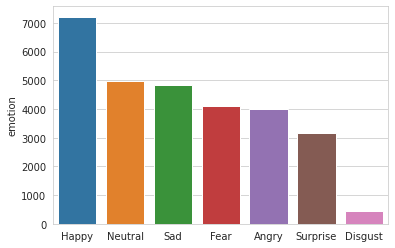

In [ ]:
sns.barplot(y="emotion",x=overview_df.index,data=overview_df)
plt.show()

In [ ]:
def rowtoimg(row):
  img=np.array(row.split())
  img=img.reshape(48,48).astype(np.uint8)
  return img

In [ ]:
def show_img():
  n_row=2
  n_col=5
  fig, axes = plt.subplots(n_row,n_col, figsize=(2*n_col,3*n_row))
  for i in range(10):
    img=rowtoimg(train_data.iloc[i,1])
    ax = axes[i//n_col, i%n_col]

    ax.set_title(emotion_map[train_data.iloc[i,0]])
    ax.imshow(img, cmap="gray")
    
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

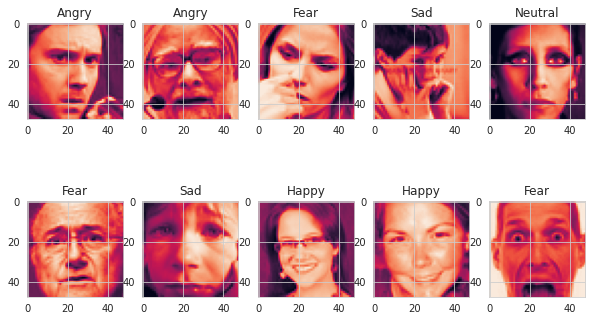

In [ ]:
show_img()

## Data Generation
The number of records of Disgust is less as compared to other categories so we generate the records to stabilize.

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# # number of images to feed into the NN for every batch
# pic_size=48
# batch_size = 128
# datagen_train = ImageDataGenerator()
# datagen_validation = ImageDataGenerator()

# train_generator = datagen_train.fit(train_data,target_size=(pic_size,pic_size),
#                                                     color_mode="grayscale",
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=True)

# validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
#                                                     target_size=(pic_size,pic_size),
#                                                     color_mode="grayscale",
#                                                     batch_size=batch_size,
#                                                     class_mode='categorical',
#                                                     shuffle=False)

## Setup Convolutional Neural Network

In [ ]:
from tensorflow.keras.layers import Dense,Input,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten,Conv2D,Dropout,MaxPool2D,Activation,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
n_classes=7
#Intialize CNN
model=Sequential()

model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(128,(5,5),padding="same"))
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.2))


model.add(Conv2D(256,(3,3),padding="same"))
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.2))

#Flatterning
model.add(Flatten())

model.add(Dense(512))  
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(.2))

model.add(Dense(128))  
# model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(.2))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

opti=Adam()

In [ ]:
model.compile(optimizer=opti,loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
activation_7 (Activation)    (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 128)      

In [ ]:
X=pd.DataFrame(train_data.iloc[:,1])
y=train_data.iloc[:,0]

In [ ]:
imgs=[]

In [ ]:
imgs.append(X.pixels.apply(lambda x:np.array(x.split()).astype(np.float32).reshape((48,48,1))))

In [ ]:
imgs1=np.array(imgs,dtype=np.float16).reshape(28709, 48, 48, 1)

In [ ]:
imgs1.shape

(28709, 48, 48, 1)

In [ ]:
imgs1 /=255.0
# X_test = X_test / 255.0

## Train Model

In [ ]:
epoch=20
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(imgs1,y,epochs=epoch,validation_split=.1, 
                    callbacks=callbacks_list)

Epoch 1/20
808/808 [==============================] - 9s 11ms/step - loss: 1.6217 - accuracy: 0.3710 - val_loss: 1.4384 - val_accuracy: 0.4375
Epoch 2/20
808/808 [==============================] - 9s 11ms/step - loss: 1.3179 - accuracy: 0.4930 - val_loss: 1.3580 - val_accuracy: 0.4612
Epoch 3/20
808/808 [==============================] - 9s 11ms/step - loss: 1.1962 - accuracy: 0.5433 - val_loss: 1.2960 - val_accuracy: 0.4939
Epoch 4/20
808/808 [==============================] - 9s 11ms/step - loss: 1.1242 - accuracy: 0.5730 - val_loss: 1.1844 - val_accuracy: 0.5549
Epoch 5/20
808/808 [==============================] - 9s 11ms/step - loss: 1.0514 - accuracy: 0.6046 - val_loss: 1.3757 - val_accuracy: 0.4835
Epoch 6/20
808/808 [==============================] - 9s 11ms/step - loss: 0.9812 - accuracy: 0.6292 - val_loss: 1.2055 - val_accuracy: 0.5531
Epoch 7/20
808/808 [==============================] - 9s 11ms/step - loss: 0.9166 - accuracy: 0.6579 - val_loss: 1.2081 - val_accuracy: 0.5545

In [ ]:
history_Without_BatchNorm = model.fit(imgs1,y,epochs=epoch,validation_split=.1, 
                    callbacks=callbacks_list)

Epoch 1/20
808/808 [==============================] - 7s 9ms/step - loss: 1.7847 - accuracy: 0.2655 - val_loss: 1.6461 - val_accuracy: 0.3462
Epoch 2/20
808/808 [==============================] - 7s 9ms/step - loss: 1.5515 - accuracy: 0.3876 - val_loss: 1.3727 - val_accuracy: 0.4556
Epoch 3/20
808/808 [==============================] - 7s 9ms/step - loss: 1.3954 - accuracy: 0.4627 - val_loss: 1.2972 - val_accuracy: 0.5040
Epoch 4/20
808/808 [==============================] - 7s 9ms/step - loss: 1.3042 - accuracy: 0.5053 - val_loss: 1.2524 - val_accuracy: 0.5183
Epoch 5/20
808/808 [==============================] - 7s 9ms/step - loss: 1.2340 - accuracy: 0.5315 - val_loss: 1.1767 - val_accuracy: 0.5430
Epoch 6/20
808/808 [==============================] - 7s 9ms/step - loss: 1.1709 - accuracy: 0.5520 - val_loss: 1.1441 - val_accuracy: 0.5590
Epoch 7/20
808/808 [==============================] - 7s 9ms/step - loss: 1.1111 - accuracy: 0.5804 - val_loss: 1.1488 - val_accuracy: 0.5723
Epoch 

In [ ]:
results=pd.DataFrame(history.history)
results.head()

,loss,accuracy,val_loss,val_accuracy
0,1.621672,0.371043,1.438360,0.437478
1,1.317946,0.492995,1.358002,0.461163
2,1.196231,0.543347,1.296004,0.493905
3,1.124224,0.572993,1.184440,0.554859
4,1.051390,0.604575,1.375706,0.483455


In [ ]:
results_Without_BatchNorm=pd.DataFrame(history_Without_BatchNorm.history)
results_Without_BatchNorm.head()

,loss,accuracy,val_loss,val_accuracy
0,1.784747,0.265539,1.646116,0.346221
1,1.551455,0.387569,1.372704,0.455590
2,1.395358,0.462691,1.297165,0.504006
3,1.304190,0.505302,1.252384,0.518286
4,1.234011,0.531465,1.176671,0.543016


In [ ]:
def plot_result(df):
  fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
  # ax=[axx for axes_rows in axes for axx in axes_rows]
  
  ax1.plot(df.index,df.loss, label='loss',color="g")
  ax1.plot(df.index,df.val_loss, label='val_loss',color="r")
  ax1.set_title("Loss")
  ax1.legend()

  ax2.plot(df.index,df.accuracy, label='accuracy',color="g")
  ax2.plot(df.index,df.val_accuracy, label='val_accuracy',color="r")
  ax2.set_title("Accuracy")
  ax2.legend()

  plt.tight_layout()
  plt.show()
  return

## Results

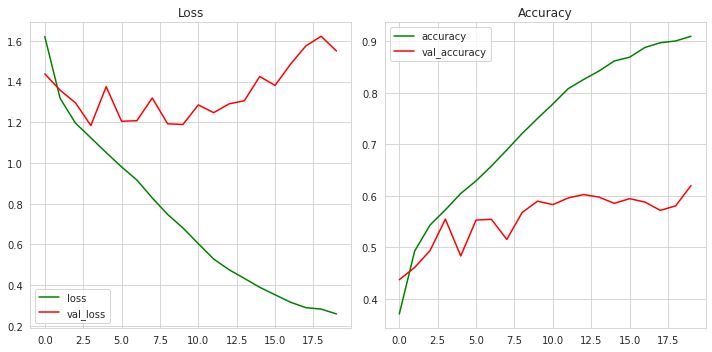

In [ ]:
plot_result(results)

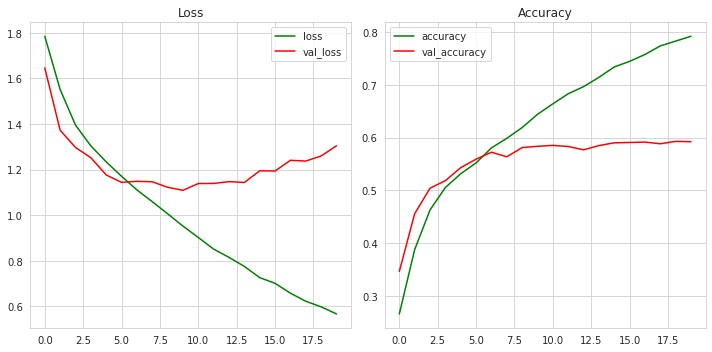

In [ ]:
plot_result(results_Without_BatchNorm)